In [1]:
# Get possible to import from parent's parent
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pickle
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from rnn_controller_tilde import RNNController
from train_RNN_powergrid import RNNController as RNNControllerOrig
from powergrid import Obs_Env as Partial_Env
from powergrid import Obs_Norm_Env as Partial_Norm_Env

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

step_num=20; hid_dim=20; state_dim=20
env = Partial_Norm_Env(1)

Instructions for updating:
non-resource variables are not supported in the long term


/home/beeperman/.conda/envs/tfrnntest/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# For tilde version!!
# Must only run once (either this one or the next one). Restart kernel if run a second time

step_num=20; hid_dim=20; state_dim=20

rnn = RNNController()
sy_mean = rnn.build_rnn(
                initstate_placeholder=None,
                input_size=env.observation_space.shape[0],
                step_num=step_num,
                output_size=env.action_space.shape[0],
                scope="rnn_policy",
                hid_nodes_size=hid_dim,
                states_size=state_dim,
                is_bias=False,
                Aphi=0,
                Bphi=1
            )

tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1) 
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
sess.__enter__() # equivalent to `with self.sess:`
tf.global_variables_initializer().run() #pylint: disable=E1101

In [2]:
# For Raw RNN!!
# Must only run once. Restart kernel if run a second time

step_num=20; hid_dim=20; state_dim=20

rnn = RNNControllerOrig()
sy_mean = rnn.build_rnn(
                initstate_placeholder=None,
                input_size=env.observation_space.shape[0],
                step_num=step_num,
                output_size=env.action_space.shape[0],
                scope="rnn_policy",
                hid_nodes_size=hid_dim,
                states_size=state_dim,
                is_bias=False,
            )

tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1) 
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
sess.__enter__() # equivalent to `with self.sess:`
tf.global_variables_initializer().run() #pylint: disable=E1101

In [3]:
def sample_trajectory(env, init_state=None, length=200):
    env.max_control = 100000

    ob = env.reset()
    if init_state is not None:
        env.state = init_state
        ob = env.get_obs()
    st = env.state
        
    sts, obs, acs, rewards, dones = [], [], [], [], []
    xi0 = np.zeros(state_dim, dtype=np.float32)
    xi = xi0
    steps = 0
    while True:
        obs.append(ob)
        sts.append(st)
        #====================================================================================#
        #                           ----------PROBLEM 3----------
        #====================================================================================#
        # raise NotImplementedError
        ac, xi = sess.run([rnn.sy1_output_na, rnn.sy1_nextstate_ns],
                               feed_dict={
                                   rnn.ph1_input_no: ob[None],
                                   rnn.ph1_initstate_ns: xi[None]
                               })
        ac = ac[0]; xi = xi[0]
        acs.append(ac)
        ob, rew, done, _ = env.step(ac)
        st = env.state
        rewards.append(rew)
        dones.append(done)
        steps += 1
        if steps > length:
            dones[-1] = True
            break
    path = {"state": np.array(sts, dtype=np.float32),
            "observation" : np.array(obs, dtype=np.float32), 
            "reward" : np.array(rewards, dtype=np.float32), 
            "action" : np.array(acs, dtype=np.float32),
            "termination": np.array(dones, dtype=np.float32)}
    return path

In [4]:
point = np.linspace(-0.01, 0.01, 10).tolist() + [0.3 for i in range(10)]

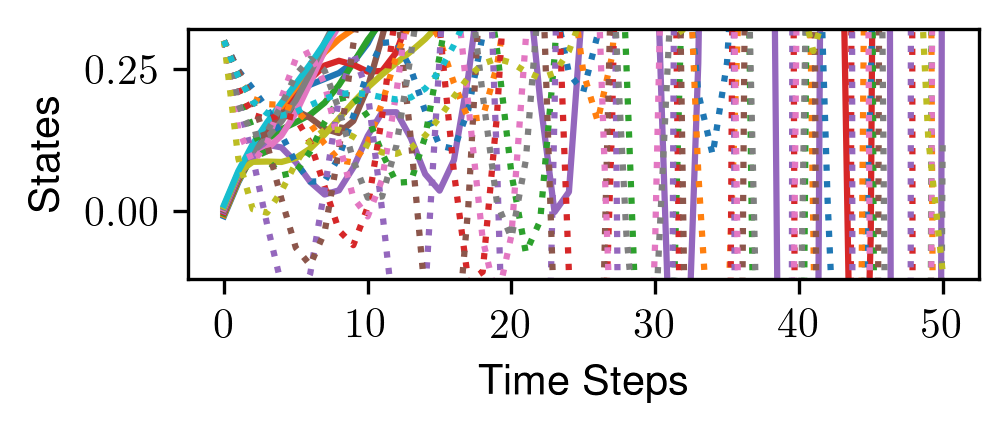

In [6]:
# horizontal plots for 1 trajectory only
proj_log_dir = "../data/powergrid_partial_norm/2/"
pklfile = proj_log_dir + "vars.pkl"

horizon = 50

with open(pklfile, "rb") as f:
    var_dict = pickle.load(f)

for v in tf.global_variables():
    sess.run(v.assign(var_dict[v.name]))
    
fig = plt.figure(dpi=300, figsize=(3.4, 1.1))
plt.ylim(-0.12, 0.32)
plt.xlabel("Time Steps")
plt.ylabel("States")

states = sample_trajectory(env, point, length=horizon)['state']

for i in range(len(states[0])):
    if i < 10:
        plt.plot(states[:, i])
    else:
        plt.plot(states[:, i], ls=":")
        

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


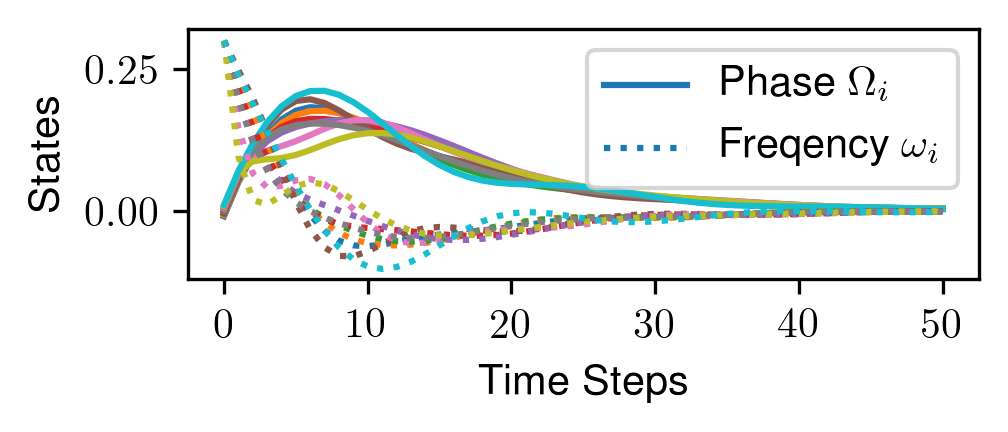

In [5]:
# horizontal plots for 1 trajectory only
proj_log_dir = "../data/powergrid_partial_norm_proj_tilde/2/"

pklfile = proj_log_dir + "vars.pkl"

horizon = 50

with open(pklfile, "rb") as f:
    var_dict = pickle.load(f)

for v in tf.global_variables():
    sess.run(v.assign(var_dict[v.name]))
    
fig = plt.figure(dpi=300, figsize=(3.4, 1.1))
plt.ylim(-0.12, 0.32)
plt.xlabel("Time Steps")
plt.ylabel("States")


states = sample_trajectory(env, point, length=horizon)['state']

lines = []

for i in range(len(states[0])):
    if i < 10:
        lines.append(plt.plot(states[:, i])[0])
    else:
        lines.append(plt.plot(states[:, i], ls=":")[0])

plt.legend([lines[0], lines[10]], ["Phase $\\Omega_i$", "Freqency $\\omega_i$"])